<a href="https://colab.research.google.com/github/dssp-ethz/DSSP-Illustrations/blob/main/Wiener_Filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wiener Filter

The non-causal Wiener filter, which estimates $X$ from $Y$ by $\hat{X} = g * Y$ is given by 

$$g * R_Y = R_{XY}$$

with $R_Y$ and $R_{XY}$ being the autocorrelation and cross-correlation respectively. Thus $h$ is the stable filter with z-Transform

$$G(z) = \frac{S_{XY} (z)}{S_Y(z)}$$

Examine the situation on page 140 in the lecture notes (as of 2020). $X$ is filtered by $h$ to produce $Z$ which is transmitted over some channel with added noise $W$. We now wish to use a filter $g$ to produce the best LMMSE estimate $\hat{X}$ of $X$.

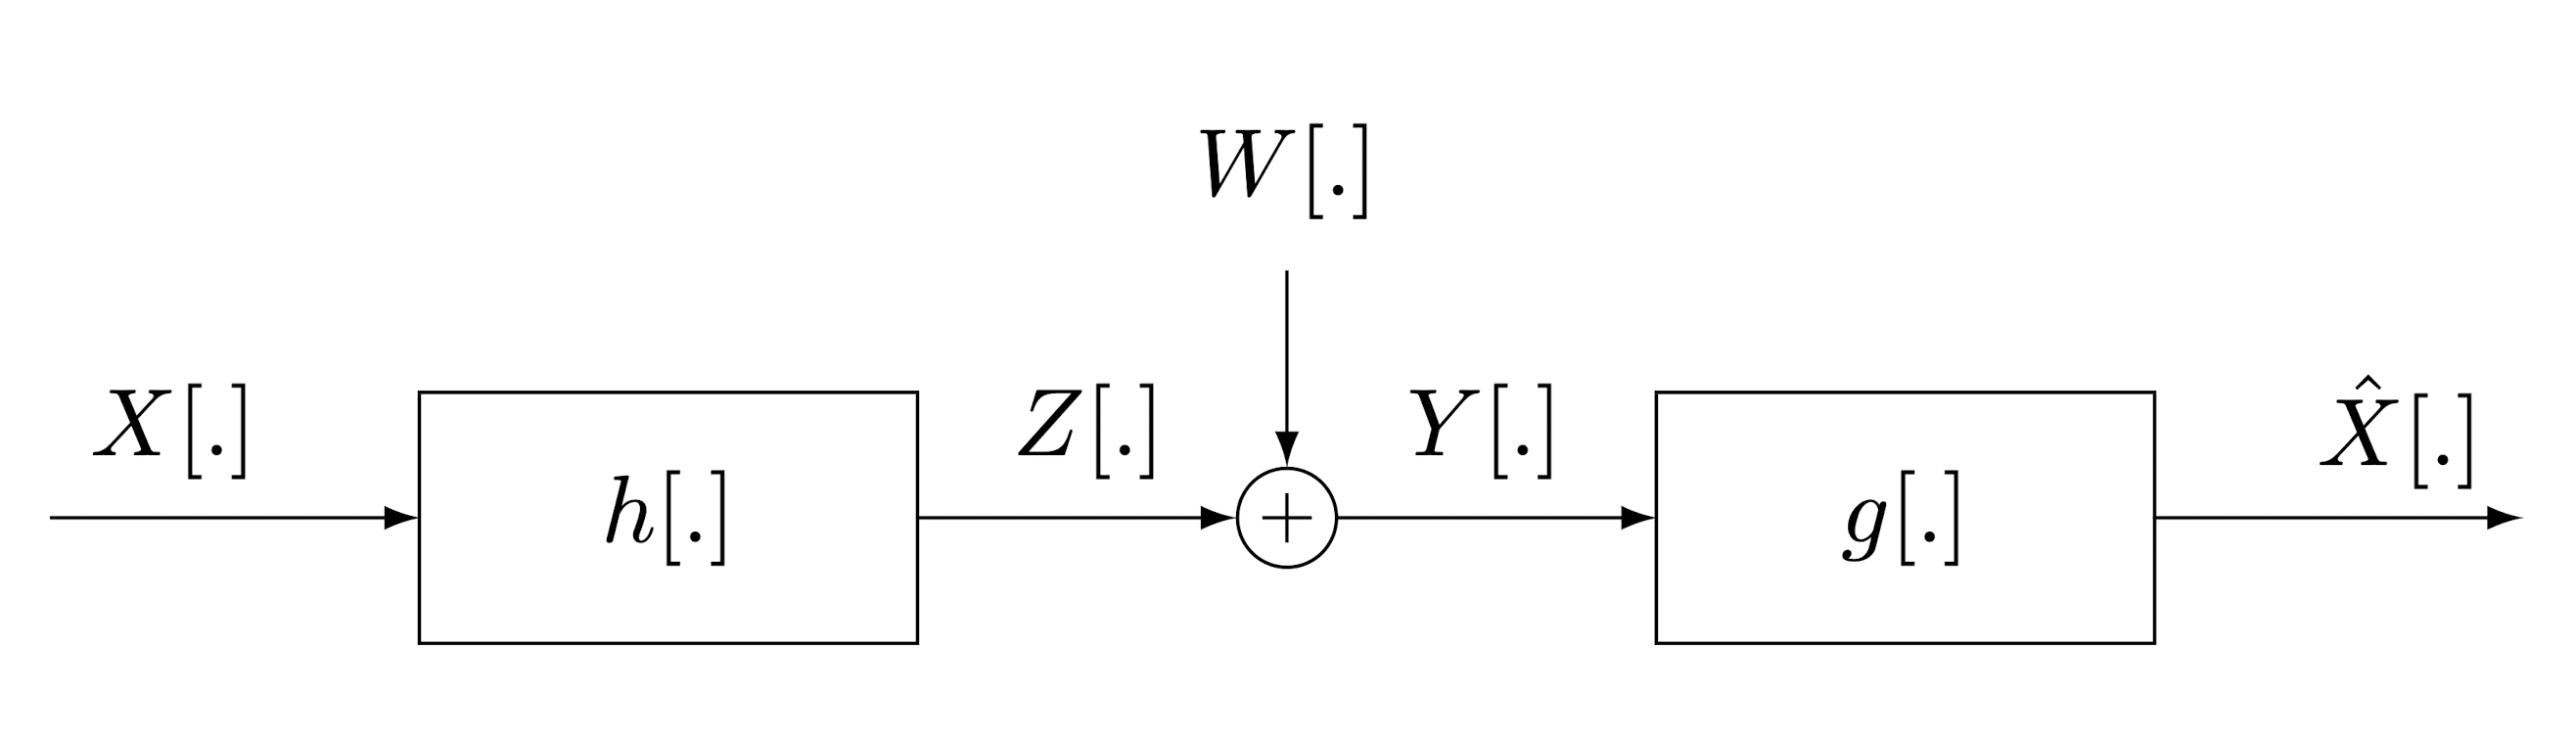

Assuming $X$ and $W$ are independent and centered (zero mean) stochastic processes we obtain
$$R_{XY} = R_{XZ} \qquad S_{XY} = S_{XZ} \qquad R_Y = R_Z + R_W \qquad S_Y = S_Z + S_W$$

Therefore we get for the noncausal Wiener filter

$$G(z) = \frac{S_{XZ}(z)}{S_Z(z) + S_W(z)} = \frac{S_X (z) H^c (z)}{S_X(z) H (z) H^c(z) + S_W(z)}$$

We notice that $G(z) H(z) = \frac{S_Z(z)}{S_Z(z) + S_W(z)}$, i.e. in this case the Wiener filter coincides with robust inversion, albeit with $\sigma$ not freely selectable.

In the following example you will get to choose different signals $X$ as input as well as different filters $h$. The channel noise $W$ is assumed to be white noise with power $\sigma^2$, i.e. $S_W(z) = \sigma^2$. Since a priori we have no information which signals are transmitted $X$ is also modelled as white noise. For this task we may assume that $X$ has power spectral density $1$ over all frequencies, i.e. $S_X(z) = 1$.

In [ ]:
pip install pydsm

     |████████████████████████████████| 552kB 6.9MB/s 
  Created wheel for pydsm: filename=pydsm-0.14.0.0-cp37-cp37m-linux_x86_64.whl size=684598 sha256=f657e192a7db0700467fd2bd98b0f825832c3961093468931dd5a08ca4c972e7
  Stored in directory: /root/.cache/pip/wheels/7d/10/8c/8983ab80da463bab42f455c100dbf62c47fba0b6650f6c22f6
Successfully built pydsm


In [ ]:
!gdown https://drive.google.com/uc?id=1-nxgfNaJPeB88X_kE5T2xDqiGI5T2I1u
!gdown https://drive.google.com/uc?id=1937_NrN8dHRPEsAamOn7v6hBSWG1cwzt

Downloading...
From: https://drive.google.com/uc?id=1-nxgfNaJPeB88X_kE5T2xDqiGI5T2I1u
To: /content/signals.py
100% 6.48k/6.48k [00:00<00:00, 10.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1937_NrN8dHRPEsAamOn7v6hBSWG1cwzt
To: /content/filters.py
100% 3.35k/3.35k [00:00<00:00, 6.59MB/s]


In [ ]:
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pydsm.ft import idtft
import signals
import filters
#-------------------------------------------------------------------------------

sigmaG = 1

logPlotG = False

#Important Stuff
################################################################################

#filter h
def h(t):
  return np.real(idtft(filters.H, t, fs = 2*np.pi)) #sets f_s such that f=Omega

#robust inversion filter G
def G(Omega):
  return np.conjugate(filters.H(Omega))/(np.abs(filters.H(Omega))**2 + sigmaG**2)

#filter g
def g(t):
  return np.real(idtft(G, t, fs = 2*np.pi)) #sets f_s such that f=Omega

#noise
def w(t):
  return np.random.normal(0,0.05,1)[0]

#received signal
def y():
  #convolution in computer is finite. Restrict signals (and filters) to nG to be able to perform computations.
  u_ = signals.time_domain_signal_long()
  h_ = [h(t) for t in signals.nG]
  w_ = [w(t) for t in np.arange(4*signals.nG.size-1)] #result of convolution has dimension (N+M-1) i.e. (nG.size+nG.size-1) = 2*nG.size-1
  r_ = np.convolve(u_,h_) + w_
  delta = len(r_) - len(u_)
  return r_[delta//2: -delta//2]

#estimation
def u_hat():
  #convolution in computer is finite. Restrict signals (and filters) to nG to be able to perform computations.
  y_ = y()
  g_ = [g(t) for t in signals.nG]
  r_ = np.convolve(y_, g_)
  delta = len(r_) - len(y_)
  return r_[delta//2: -delta//2]
################################################################################

#drawing plots
def plot():
  Omega_values = np.linspace(-np.pi, np.pi, 200)
  H_values = [filters.H(Omega) for Omega in Omega_values]
  G_values = [G(Omega) for Omega in Omega_values]

  fig = plt.figure(figsize=(20, 8))

  ax1 = fig.add_subplot(1, 2, 1)
  ax1.grid()
  ax1.set_title('transmission filter')
  ax1.set_xlabel('$\Omega$', fontsize=14)
  ax1.set_ylabel('$H(e^{i\Omega})$', fontsize=14)
  if logPlotG == False:
    ax1.axis(xmin=Omega_values[0], xmax=Omega_values[-1], ymin=0, ymax=1.5)
    ax1.plot(Omega_values, H_values, alpha=0.5);
  else:
    ax1.axis(xmin=Omega_values[0], xmax=Omega_values[-1], ymin = 0.1, ymax = 1.5)
    ax1.semilogy(Omega_values, H_values, alpha=0.5);

  ax2 = fig.add_subplot(1, 2, 2)
  ax2.grid()
  ax2.set_title('inversion filter')
  ax2.set_xlabel('$\Omega$', fontsize=14)
  ax2.set_ylabel('$G(e^{i\Omega})$', fontsize=14)
  if logPlotG == False:
    ax2.axis(xmin=Omega_values[0], xmax=Omega_values[-1], ymin=0, ymax=1.5)
    ax2.plot(Omega_values, G_values, alpha=0.5);
  else:
    ax2.axis(xmin=Omega_values[0], xmax=Omega_values[-1], ymin = 0.1, ymax = 1.5)
    ax2.semilogy(Omega_values, G_values, alpha=0.5);

def plot_time():
  t1_values = np.arange(3*np.min(signals.nG), 3*np.max(signals.nG)+3)
  u_values = signals.time_domain_signal_long()
  t2_values = np.arange(3*np.min(signals.nG), 3*np.max(signals.nG)+3)
  y_values = y()
  t3_values = np.arange(3*np.min(signals.nG), 3*np.max(signals.nG)+3)
  u_hat_values = u_hat()


  fig = plt.figure(figsize=(20, 8))

  ax1 = fig.add_subplot(1, 3, 1)
  ax1.grid()
  ax1.set_title('original signal')
  ax1.set_xlabel('$k$', fontsize=14)
  ax1.set_ylabel('$u(k)$', fontsize=14)
  ax1.axis(xmin=t1_values[0], xmax=t1_values[-1])
  if logPlotG == False:
    ax1.axis(ymin=-3, ymax=3)
    ax1.plot(t1_values, u_values, alpha=0.5, marker='o', markersize=8);
  else:
    ax1.axis(ymin=0.1, ymax=3)
    ax1.semilogy(t1_values, u_values, alpha=0.5, marker='o', markersize=8);

  ax2 = fig.add_subplot(1, 3, 2)
  ax2.grid()
  ax2.set_title('received signal')
  ax2.set_xlabel('$k$', fontsize=14)
  ax2.set_ylabel('$y(k)$', fontsize=14)
  ax2.axis(xmin=t2_values[0], xmax=t2_values[-1])
  if logPlotG == False:
    ax2.axis(ymin=-3, ymax=3)
    ax2.plot(t2_values, y_values, alpha=0.5, marker='o', markersize=8);
  else:
    ax2.axis(ymin=0.1, ymax=3)
    ax2.semilogy(t2_values, y_values, alpha=0.5, marker='o', markersize=8);

  ax3 = fig.add_subplot(1, 3, 3)
  ax3.grid()
  ax3.set_title('reconstructed signal')
  ax3.set_xlabel('$k$', fontsize=14)
  ax3.set_ylabel('$\hat{u}(k)$', fontsize=14)
  ax3.axis(xmin=t3_values[0], xmax=t3_values[-1])
  if logPlotG == False:
    ax3.axis(ymin=-3, ymax=3)
    ax3.plot(t3_values, u_hat_values, alpha=0.5, marker='o', markersize=8);
  else:
    ax3.axis(ymin=0.1, ymax=3)
    ax3.semilogy(t3_values, u_hat_values, alpha=0.5, marker='o', markersize=8);

In [ ]:
signals.widget()
filters.widget()

def update_parameters(sigma, logPlot):
  global sigmaG, logPlotG
  sigmaG, logPlotG = sigma, logPlot

widgets.interact(update_parameters,
  sigma = widgets.FloatSlider(
    value=1,
    min=0.01,
    max=10,
    description='sigma'),
  logPlot = widgets.Checkbox(
    value=False,
    description='logarithmic plot')
);

interactive(children=(Dropdown(description='signal type', options=('unit step', 'unit impulse', 'ramp', 'expon…

interactive(children=(Dropdown(description='filter type', options=('low pass', 'high pass', 'band pass', 'all …

interactive(children=(FloatSlider(value=1.0, description='sigma', max=10.0, min=0.01), Checkbox(value=False, d…

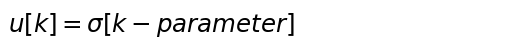

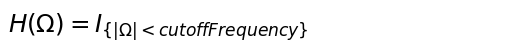

In [ ]:
signals.display_signal_selection(continuous=False)
filters.display_filter_selection(continuous=False)

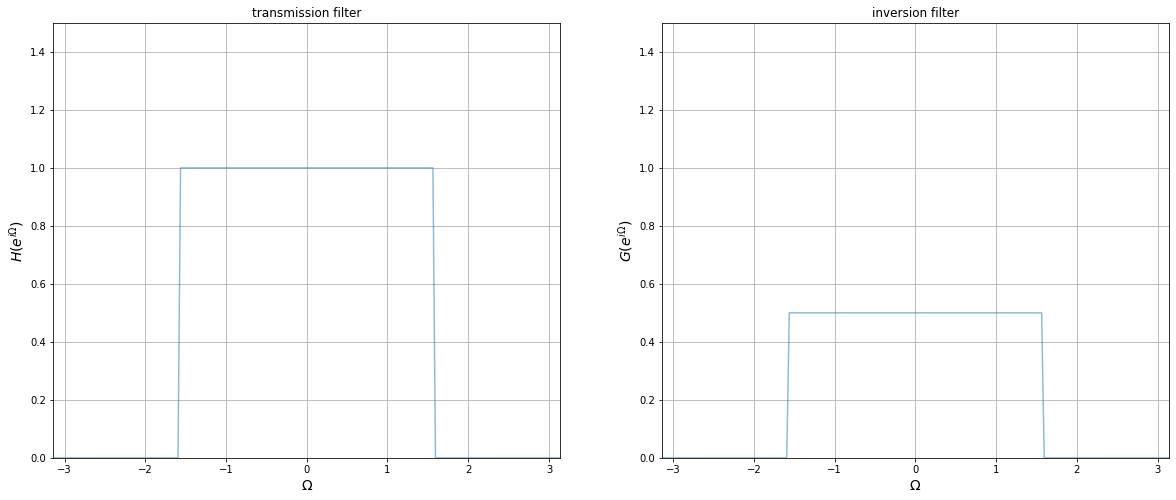

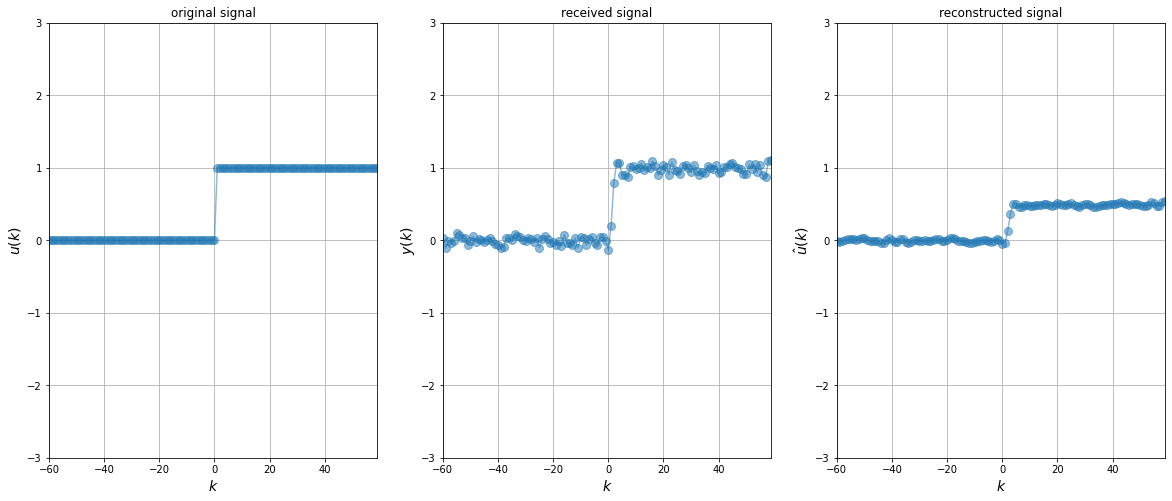

In [ ]:
plot()
plot_time()

# Application: Deblurring an image

Assume you changed career and became a photographer. You have taken an amazing photo of your friend. You want to send her the photograph, but you are afraid to fall victim of a man-in-the-middle attack. You surely do not want somebody else to claim your photo, so remembering your course on DSSP you apply a filter to deblur the image and you add some (white) gaussian noise, just to be sure. You call your friend to hear her opinion on the photograph. Although your friend recognizes the potential of the image she sounds upset that it is all blurry and noisy. Help her to recover her photo and gain her grace!

The data model is
$$Y = h * X + W$$
where $X$ is the original image, $h$ is the applied (2D) filter and $W$ the white noise producing the deblurred image $Y$. First, decide on a filter and the amount of white noise introduced:

In [ ]:
import ipywidgets as widgets

import parser
import numpy as np
sG = 1
hG = np.array([[1, 2, 2, 1],[1, 2, 2, 1],[1, 2, 2, 1],[1, 2, 2, 1]])/16
hTrueG = None

def padding(array, xx, yy):
    """
    :param array: numpy array
    :param xx: desired height
    :param yy: desirex width
    :return: padded array
    """

    h = array.shape[0]
    w = array.shape[1]

    aa = xx - h
    bb = yy - w

    return np.pad(array, pad_width=((0, aa), (0, bb)), mode='constant')

def update_filter_noise(s, h):
  global sG, hG, hTrueG
  matrix = parser.expr(h).compile()
  sG, hG = s, np.array(eval(matrix))
  hTrueG = padding(hG, 160, 104) #image will have dimension (160, 104), kernel/filter must have same dimension for DFT filtering
  print("h = ")
  for row in hG:
    print(row)

widgets.interact(update_filter_noise,
  s = widgets.FloatSlider(
    value=0.05,
    min=0.001,
    max=0.1,
    step=0.001,
    description='sigma'),
  h = widgets.Text(
    value='np.array([[1, 2, 2, 1],[1, 5, 5, 1],[1, 5, 5, 1],[1, 2, 2, 1]])/16',
    description='h')
);

interactive(children=(FloatSlider(value=0.05, description='sigma', max=0.1, min=0.001, step=0.001), Text(value…

Being sure that your friend will be impressed beyond imagination once she sees the original photo you want to give her a sustainable way to get her photo back, in sight of many more to come. Thus you once again assume that the random variable $X$ describing the original photos is white noise with unit power, i.e. $S_X(z) = 1$. Now the Wiener filter is given by
$$G(z) = \frac{S_{XZ}(z)}{S_Z(z) + S_W(z)} = \frac{S_X (z) H^c (z)}{S_X(z) H (z) H^c(z) + S_W(z)} = \frac{H^c (z)}{|H (z)|^2 + \sigma^2}$$

As a side note, in the following scripts the discrete time (space) fourier transform is approximated by a 2 dimensional DFT (FFT). The same concepts apply.

In [ ]:
import numpy as np

def G():
  return np.conjugate(H())/(np.abs(H())**2 + sG**2)

def H():
  return np.fft.fft2(hTrueG)

#filter g
def g():
  return np.real(np.fft.ifft2(G()))

In [ ]:
!gdown https://drive.google.com/uc?id=1dzGhSEEQTGSKa-clAkAygNOEnvX2cyhz

Downloading...
From: https://drive.google.com/uc?id=1dzGhSEEQTGSKa-clAkAygNOEnvX2cyhz
To: /content/image_woman.jpg
100% 231k/231k [00:00<00:00, 7.39MB/s]


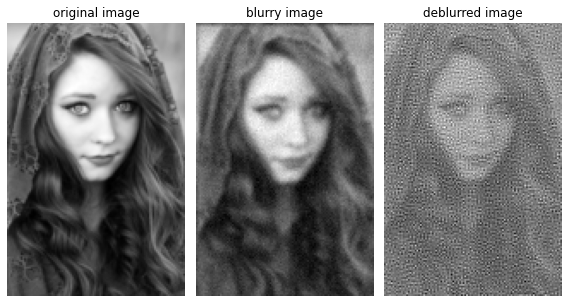

In [ ]:
from matplotlib import image
import matplotlib.pyplot as plt
from skimage import color, transform

#circular convolution as is present with dft
def conv_circ(signal, ker):
    return np.real(np.fft.ifft2(np.fft.fft2(signal)*np.fft.fft2(ker)))

#import image
woman_image = image.imread('image_woman.jpg')
woman_image = transform.resize(color.rgb2gray(woman_image), (woman_image.shape[0] // 8, woman_image.shape[1] // 8),
                       anti_aliasing=True)

#introduce blurring
woman_image_blurred = conv_circ(woman_image, hTrueG)
woman_image_blurred += np.random.normal(loc = 0, scale = sG, size = woman_image_blurred.shape)
deconvolved = conv_circ(woman_image_blurred, g())

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 5),
                       sharex=True, sharey=True)

plt.gray()

ax[0].imshow(woman_image, vmin=woman_image.min(), vmax=woman_image.max())
ax[0].axis('off')
ax[0].set_title('original image')

ax[1].imshow(woman_image_blurred, vmin=woman_image_blurred.min(), vmax=woman_image_blurred.max())
ax[1].axis('off')
ax[1].set_title('blurry image')

ax[2].imshow(deconvolved, vmin=deconvolved.min(), vmax=deconvolved.max())
ax[2].axis('off')
ax[2].set_title('deblurred image')

fig.tight_layout()

plt.show()

As you can see, your friend will be properly pleased once you give her the coefficients of the inverse filter $G$. You are happy that you took this course and are curious what the future holds for you both.